In [1]:
%matplotlib inline

from __future__ import print_function
from statsmodels.compat import lzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

/home/vinni/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
beef = pd.read_csv('beef.csv')

In [3]:
beef.head(10)

,Year,Quarter,Quantity,Price
0,1977,1,22.9976,142.1667
1,1977,2,22.6131,143.9333
2,1977,3,23.4054,146.5000
3,1977,4,22.7401,150.8000
4,1978,1,22.0441,160.0000
5,1978,2,21.7602,182.5333
6,1978,3,21.6064,186.2000
7,1978,4,21.8814,186.4333
8,1979,1,20.5086,211.7000
9,1979,2,19.0408,231.5000


In [4]:
beef.isnull().sum()

Year        0
Quarter     0
Quantity    0
Price       0
dtype: int64

## Regression Analysis

### Ordinary Least Squares (OLS) Estimation

In [5]:
beef_model = ols("Quantity ~ Price", data=beef).fit()

In [6]:
print(beef_model.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     811.2
Date:                Sun, 17 Feb 2019   Prob (F-statistic):           1.69e-46
Time:                        08:03:21   Log-Likelihood:                -77.493
No. Observations:                  91   AIC:                             159.0
Df Residuals:                      89   BIC:                             164.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.0515      0.413     72.701      0.0

The small P values indicate that we can reject the null hypothesis that Price has no effect on Quantity.

Hight r squared indicates that our model explains a lot of the response variability.

In regression analysis, we'd like our regression model to have significant variables and to produce a high R-squared value.

We will show graphs to help interpret regression analysis results more intuitively.

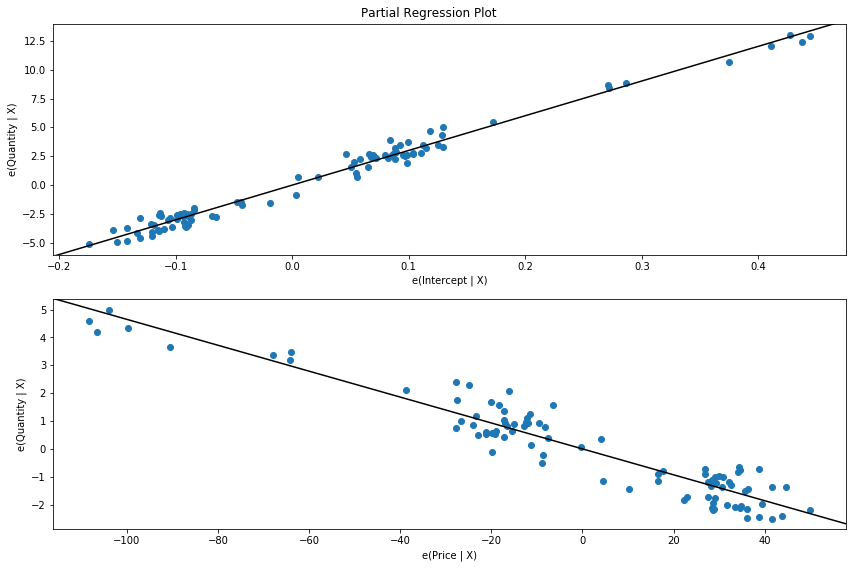

In [7]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(beef_model, fig=fig)

The trend indicates that the predictor variables (Price) provides information about the response (Quantity), and data points do not fall further from the regression line, and the predictions are very precise given a prediction interval that extends from about 29 to 31.

### Component-Component plus Residual (CCPR) Plots

The CCPR plot provides a way to judge the effect of one regressor on the response variable by taking into account the effects of the other independent variables.

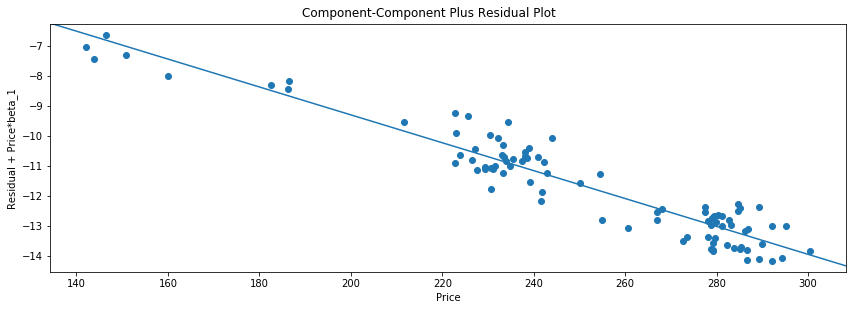

In [8]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_ccpr_grid(beef_model, fig=fig)

### Regression plots

We use plot_regress_exog function to quickly check model assumptions with respect to a single regressor, Price in our case.

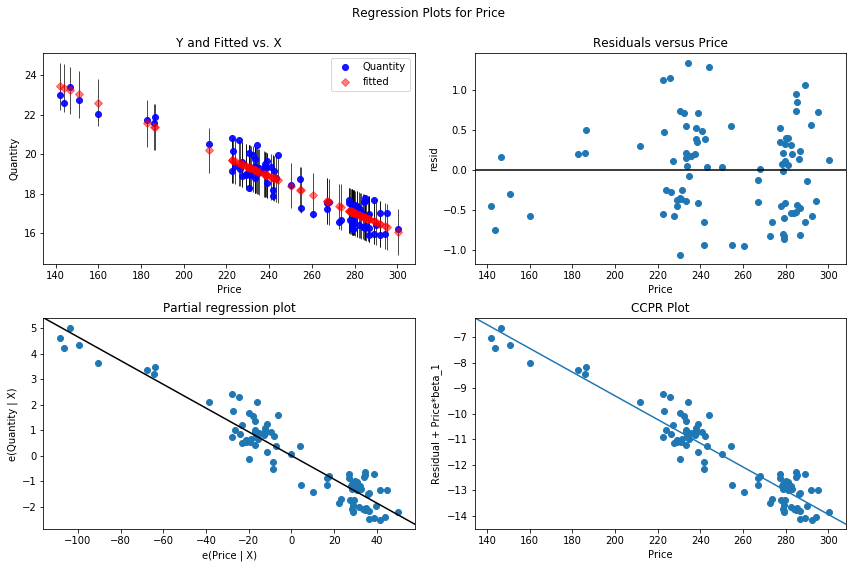

In [9]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(beef_model, 'Price', fig=fig)

### Recursive Least Square (RLS)

Finally we apply Recursive Least Square (RLS) filter to investigate parameter instability.

In [10]:
beef['Year'] = pd.to_datetime(beef['Year'], format="%Y")

In [11]:
beef.head()

,Year,Quarter,Quantity,Price
0,1977-01-01,1,22.9976,142.1667
1,1977-01-01,2,22.6131,143.9333
2,1977-01-01,3,23.4054,146.5000
3,1977-01-01,4,22.7401,150.8000
4,1978-01-01,1,22.0441,160.0000


In [12]:
from pandas.tseries.offsets import *
beef['Date'] = beef.apply(lambda x:(x['Year'] + BQuarterBegin(x['Quarter'])), axis=1)

In [13]:
beef.drop(['Year', 'Quarter'], axis=1, inplace=True)

In [14]:
beef.set_index('Date', inplace=True)

In [15]:
beef.head(10)

,Quantity,Price
Date,,
1977-03-01,22.9976,142.1667
1977-06-01,22.6131,143.9333
1977-09-01,23.4054,146.5000
1977-12-01,22.7401,150.8000
1978-03-01,22.0441,160.0000
1978-06-01,21.7602,182.5333
1978-09-01,21.6064,186.2000
1978-12-01,21.8814,186.4333
1979-03-01,20.5086,211.7000


In [16]:
endog = beef['Quantity']

# To the regressors in the dataset, we add a column of ones for an intercept
exog = sm.add_constant(beef['Price'])

### RLS estimation

In [17]:
mod = sm.RecursiveLS(endog, exog)
res = mod.fit()

print(res.summary())

                           Statespace Model Results                           
Dep. Variable:               Quantity   No. Observations:                   91
Model:                    RecursiveLS   Log Likelihood                 -84.326
Date:                Sun, 17 Feb 2019   AIC                            172.653
Time:                        08:04:48   BIC                            177.675
Sample:                    03-01-1977   HQIC                           174.679
                         - 09-01-1999                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.0515      0.413     72.700      0.000      29.241      30.862
Price         -0.0465      0.002    -28.482      0.000      -0.050      -0.043
Ljung-Box (Q):                      422.30   Jarque-

The RLS model computes the regression parameters recursively, so there are as many estimates as there are datapoints, the summary table only presents the regression parameters estimated on the entire sample; these estimates are equivalent to OLS estimates.

### RLS plots

We can generate the recursively estimated coefficients plot on a given variable.

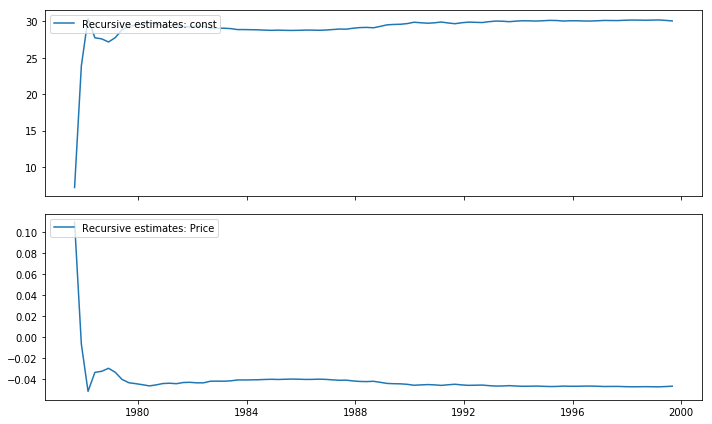

In [18]:
res.plot_recursive_coefficient(range(mod.k_exog), alpha=None, figsize=(10,6));

For convenience, we visually check for parameter stability using the plot_cusum function.

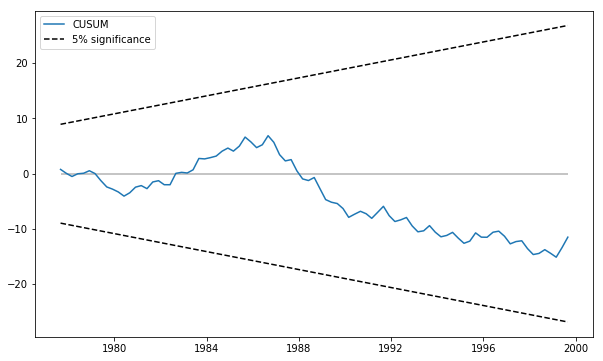

In [19]:
fig = res.plot_cusum(figsize=(10,6));

In the plot above, the CUSUM statistic does not move outside of the 5% significance bands, so we fail to reject the null hypothesis of stable parameters at the 5% level.